# Analysis of simulations of 2D Ising model with Wolff algorithm

#### Marco Zenari

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os #to read file names
import re #regular expression to infer parameters from filenames

In [2]:
#Creating a list with the names of the files
path='data_cluster_distributions/'
filenames = os.listdir(path)
filenames = sorted(filenames,) #ordering the filenames

In [3]:
filenames

['Ising_2D_wolff_N2500_L50_beta0.220350time20000.txt',
 'Ising_2D_wolff_N2500_L50_beta0.440500time20000.txt',
 'Ising_2D_wolff_N2500_L50_beta0.881400time20000.txt']

## Histograms of cluster sizes

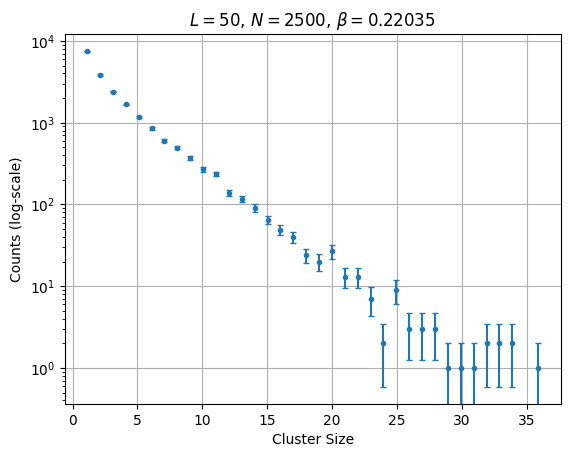

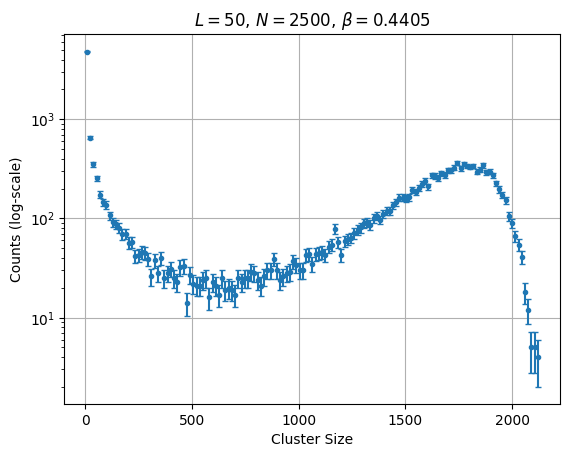

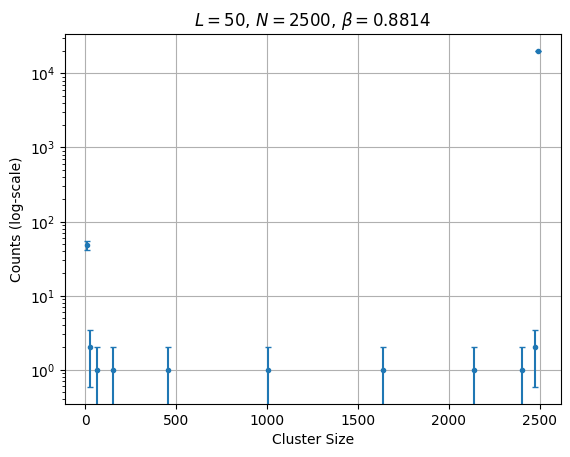

In [4]:
for i, file in enumerate(filenames):
    #choosing the file to analyze and loading the data
    data = np.loadtxt(fname=path+file)
    data = data[1:]
    
    
    #extract parameters of the simulation with regex
    pattern_N = r'N(.*?)_'
    N = int(re.search(pattern_N, file).group(1))

    pattern_L = r'L(.*?)_'
    L = int(re.search(pattern_L, file).group(1))

    pattern_beta = r'beta(.*?)time'
    beta = float(re.search(pattern_beta, file).group(1))

    pattern_time = r'time(.*?).txt'
    time = int(re.search(pattern_time, file).group(1))
    
    
    #HISTOGRAMMMING THE CLUSTER SIZES
    counts, bin_edges = np.histogram(pd.DataFrame(data[:,3]), bins=int(np.sqrt(time)))
    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    
    #Plot of histograms
    plt.figure()
    plt.xscale('linear')
    plt.yscale('log')
    plt.errorbar(bin_centers, counts, np.sqrt(counts), linestyle='None', fmt='.', capsize=2)
    plt.xlabel('Cluster Size')
    plt.ylabel('Counts (log-scale)')
    plt.title(r'$L={}$, $N={}$, $\beta={}$'.format(L, N, beta))
    plt.grid()
    plt.savefig('plots/cluster_dist_{}.png'.format(file))

# Autocorrelation times comparison

In [3]:
#Creating a list with the names of the files
path='data_autocorrelation/'
filenames = os.listdir(path)
filenames = sorted(filenames,) #ordering the filenames

In [4]:
filenames

['Ising_2D_glauber_metropolis_N100_L10_beta0.426000time500000.txt',
 'Ising_2D_glauber_metropolis_N1600_L40_beta0.437000time500000.txt',
 'Ising_2D_glauber_metropolis_N400_L20_beta0.437000time500000.txt',
 'Ising_2D_glauber_metropolis_N900_L30_beta0.438000time500000.txt',
 'Ising_2D_wolff_N100_L10_beta0.426000time100000.txt',
 'Ising_2D_wolff_N1600_L40_beta0.437000time100000.txt',
 'Ising_2D_wolff_N400_L20_beta0.437000time100000.txt',
 'Ising_2D_wolff_N900_L30_beta0.438000time100000.txt']

In [5]:
equilibration_times = [40000 for i in range(len(filenames))]

In [6]:
## Data frame to save summary of simulations
col =['algorithm','L', 'N', 'beta', 'time', 't_eq',
      'av_mag', 'var_mag', 't_aut_mag',
      'av_en', 'var_en', 't_aut_en', 'av_clust_size']
df_simul=pd.DataFrame(columns= col)

Functions to compute the autocorrelation function of a time-series and the correlation time

In [7]:
def autocorrelation_function(O, max_time = 5000):
    #takes in input a time-series   
    O = np.array(O)
    if(len(O)>max_time):
        t_max=max_time
    else:
        t_max = len(O)
        
    C = np.zeros(t_max)
    for t in range(t_max):
        C1=1/(t_max-t)*np.sum(O[:t_max-t]*O[t:t_max])
        C2=1/(t_max-t)*np.sum(O[:t_max-t])
        C3=1/(t_max-t)*np.sum(O[t:t_max])
        C[t]=C1-C2*C3
    return C

In [8]:
def autocorrelation_time(C):
    tau = np.argmax(C<C[0]/np.e)
    return tau

## Analysis of simulations

In [9]:
for i, file in enumerate(filenames):
    #equilibration time
    t_eq = equilibration_times[i]
    
    #choosing the file to analyze and loading the data
    data = np.loadtxt(fname=path+file)
    
    #extract parameters of the simulation with regex
    pattern_N = r'N(.*?)_'
    N = int(re.search(pattern_N, file).group(1))

    pattern_L = r'L(.*?)_'
    L = int(re.search(pattern_L, file).group(1))

    pattern_beta = r'beta(.*?)time'
    beta = float(re.search(pattern_beta, file).group(1))

    pattern_time = r'time(.*?).txt'
    time = int(re.search(pattern_time, file).group(1))
    
    #extracting the algorithm used for the simulation
    word_to_find = 'wolff'
    if word_to_find in file:
        algorithm = 'Wolff'
    else:
        algorithm ='Glauber'
    
    if algorithm =='Wolff':
        #Saving data in a Pandas Dataframe
        df = pd.DataFrame(data, columns=['time', 'energy', 'magnetization', 'cluster_size'])

        #adding energy per spin observable
        df['energy_per_spin']=df['energy']/N
        df['mag_per_spin']=np.abs(df['magnetization'])/N

        #computing the correlation time of each observable
        C_mag = autocorrelation_function(df['mag_per_spin'][t_eq:])
        tau_mag=autocorrelation_time(C_mag)

        C_en = autocorrelation_function(np.array(df['energy_per_spin'][t_eq:]))
        tau_en = autocorrelation_time(C_en)

        ## COMPUTING AVERAGES SAMPLING EVERY TAU_AUTOCORRELATION
        #computing averages and fluctuations of observables
        av_mag = np.mean(df['mag_per_spin'][t_eq:][0::tau_mag])
        var_mag =np.mean((df['mag_per_spin'][t_eq:][0::tau_mag]-av_mag)**2)

        av_en = np.mean(df['energy_per_spin'][t_eq:][0::tau_en])
        var_en = np.mean((df['energy_per_spin'][t_eq:][0::tau_en]-av_en)**2)

        ## COMPUTING AVERAGES SAMPLING EVERY POINT AND CORRECTING VARIANCE
        #computing averages and fluctuations of observables
        #av_mag = np.mean(df['mag_per_spin'][t_eq:])
        #var_mag = 1/(time-t_eq-1)*np.sum((df['mag_per_spin'][t_eq:]-av_mag)**2)

        #av_en = np.mean(df['energy_per_spin'][t_eq:])
        #var_en = 1/(time-t_eq-1)*np.sum((df['energy_per_spin'][t_eq:]-av_en)**2)

        #Correcting the estimation of variance with correlation time
        #var_mag = (1+2*tau_mag)*var_mag
        #var_en = (1+2*tau_en)*var_en

        ##IGNORE CORRELATION
        #av_mag = np.mean(df['mag_per_spin'][t_eq:])
        #var_mag =np.mean((df['mag_per_spin'][t_eq:]-av_mag)**2)

        #av_en = np.mean(df['energy_per_spin'][t_eq:])
        #var_en = np.mean((df['energy_per_spin'][t_eq:]-av_en)**2)
        
        nbins = 100
        setoff=20
        count, bin_edges = np.histogram(df['cluster_size'].fillna(0), bins=nbins)
        bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
        idx = np.argmax(count[setoff:])
        av_clust_size = bin_centers[idx+setoff]
        #appending data of simulation to pd.dataframe
        df_simul.loc[len(df_simul)] = [algorithm, L, N, beta, time, t_eq,
                                       av_mag, var_mag, tau_mag,
                                       av_en, var_en, tau_en, av_clust_size]  
    else:
            #Saving data in a Pandas Dataframe
        df = pd.DataFrame(data, columns=['time', 'energy', 'magnetization'])

        #adding energy per spin observable
        df['energy_per_spin']=df['energy']/N
        df['mag_per_spin']=np.abs(df['magnetization'])/N

        #computing the correlation time of each observable
        C_mag = autocorrelation_function(df['mag_per_spin'][t_eq:])
        tau_mag=autocorrelation_time(C_mag)

        C_en = autocorrelation_function(np.array(df['energy_per_spin'][t_eq:]))
        tau_en = autocorrelation_time(C_en)

        ## COMPUTING AVERAGES SAMPLING EVERY TAU_AUTOCORRELATION
        #computing averages and fluctuations of observables
        av_mag = np.mean(df['mag_per_spin'][t_eq:][0::tau_mag])
        var_mag =np.mean((df['mag_per_spin'][t_eq:][0::tau_mag]-av_mag)**2)

        av_en = np.mean(df['energy_per_spin'][t_eq:][0::tau_en])
        var_en = np.mean((df['energy_per_spin'][t_eq:][0::tau_en]-av_en)**2)

        ## COMPUTING AVERAGES SAMPLING EVERY POINT AND CORRECTING VARIANCE
        #computing averages and fluctuations of observables
        #av_mag = np.mean(df['mag_per_spin'][t_eq:])
        #var_mag = 1/(time-t_eq-1)*np.sum((df['mag_per_spin'][t_eq:]-av_mag)**2)

        #av_en = np.mean(df['energy_per_spin'][t_eq:])
        #var_en = 1/(time-t_eq-1)*np.sum((df['energy_per_spin'][t_eq:]-av_en)**2)

        #Correcting the estimation of variance with correlation time
        #var_mag = (1+2*tau_mag)*var_mag
        #var_en = (1+2*tau_en)*var_en

        ##IGNORE CORRELATION
        #av_mag = np.mean(df['mag_per_spin'][t_eq:])
        #var_mag =np.mean((df['mag_per_spin'][t_eq:]-av_mag)**2)

        #av_en = np.mean(df['energy_per_spin'][t_eq:])
        #var_en = np.mean((df['energy_per_spin'][t_eq:]-av_en)**2)

        #appending data of simulation to pd.dataframe
        df_simul.loc[len(df_simul)] = [algorithm, L, N, beta, time, t_eq,
                                       av_mag, var_mag, tau_mag,
                                       av_en, var_en, tau_en, 1]  


In [10]:
##Computing also specific heat and magnetic susceptibility
df_simul['Cv']=df_simul['var_en']*df_simul['beta']**2
df_simul['Xt']=df_simul['var_mag']*df_simul['beta']*df_simul['N']

In [11]:
df_simul

algorithm   L     N   beta    time   t_eq    av_mag   var_mag  t_aut_mag  \
0   Glauber  10   100  0.426  500000  40000  0.682110  0.055013         14   
1   Glauber  40  1600  0.437  500000  40000  0.564802  0.040430        170   
2   Glauber  20   400  0.437  500000  40000  0.659045  0.040425        112   
3   Glauber  30   900  0.438  500000  40000  0.620217  0.037504         95   
4     Wolff  10   100  0.426  100000  40000  0.682811  0.054542          2   
5     Wolff  40  1600  0.437  100000  40000  0.573284  0.037223          3   
6     Wolff  20   400  0.437  100000  40000  0.657700  0.040936          3   
7     Wolff  30   900  0.438  100000  40000  0.621676  0.037447          3   

      av_en    var_en  t_aut_en  av_clust_size        Cv         Xt  
0 -1.373755  0.072480         9          1.000  0.013153   2.343563  
1 -1.389691  0.006519        41          1.000  0.001245  28.268648  
2 -1.410737  0.021576        41          1.000  0.004120   7.066283  
3 -1.407215  0.010868        26          1.000  0.002085  14.784175  
4 -1.374811  0.072510         2         84.500  0.013159   2.323476  
5 -1.391996  0.006670         5       1170.670  0.001274  26.026498  
6 -1.411186  0.021934         3        319.805  0.004189   7.155589  
7 -1.408247  0.010867         5        683.030  0.002085  14.761471

## Plot of autocorrelation time vs systems size

In [12]:
#Data
x_glauber = np.log(df_simul['L'][df_simul['algorithm']=='Glauber'])
y_glauber = np.log(df_simul['t_aut_mag'][df_simul['algorithm']=='Glauber'])

x_wolff=np.log(df_simul['L'][df_simul['algorithm']=='Wolff'])
y_wolff=np.log((df_simul['t_aut_mag']*df_simul['av_clust_size']/df_simul['N'])[df_simul['algorithm']=='Wolff'])

In [13]:
##Fit
#Glauber
fit_glauber=np.polyfit(x_glauber,y_glauber,deg=1)
z_glauber=fit_glauber[0]
#Wolff
fit_wolff=np.polyfit(x_wolff,y_wolff,deg=1)
z_wolff=fit_wolff[0]

In [14]:
print('z for Glauber:', z_glauber)
print('z for Wolff:', z_wolff)

z for Glauber: 1.7054234204265055
z for Wolff: 0.19356381888171714


In [15]:
#Data to plot the fit
x_fit = np.log(np.linspace(8, 42, 1000))
y_fit_glauber = fit_glauber[0]*x_fit + fit_glauber[1]
y_fit_wolff = fit_wolff[0]*x_fit + fit_wolff[1]

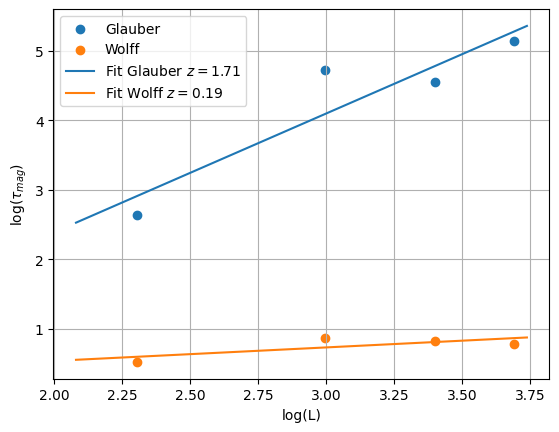

In [20]:
plt.scatter(x_glauber, y_glauber, label='Glauber')
plt.scatter(x_wolff, y_wolff, label='Wolff')
plt.plot(x_fit, y_fit_glauber, label=r'Fit Glauber $z={0:.2f}$'.format(z_glauber))
plt.plot(x_fit, y_fit_wolff, label=r'Fit Wolff $z={0:.2f}$'.format(z_wolff))
plt.xlabel('log(L)')
plt.ylabel(r'log$(\tau_{mag})$')


plt.legend()
plt.grid()

plt.savefig('plots/critical_slowing_down')

# Multiple Markov Chains with Glauber Metropolis and Swap

In [75]:
#Creating a list with the names of the files
path='data_MMC/'
filenames = os.listdir(path)
filenames = sorted(filenames,) #ordering the filenames

In [76]:
#Chosen value of temperature
beta = [0.41, 0.42, 0.43, 0.44, 0.45, 0.46]
L=20
N=L*L

In [77]:
filenames

['Ising_2D_MMC_glauber_NO_SWAP_N400_L20_Nchains6time30000.txt',
 'Ising_2D_MMC_glauber_SWAP_N400_L20_Nchains6time30000.txt',
 'Ising_2D_MMC_wolff_NO_SWAP_N400_L20_Nchains6time30000.txt',
 'Ising_2D_MMC_wolff_SWAP_N400_L20_Nchains6time30000.txt']

In [78]:
file_swap = filenames[3]
file_no_swap = filenames[2]

## Swap alllowed

In [79]:
path+file_swap

'data_MMC/Ising_2D_MMC_wolff_SWAP_N400_L20_Nchains6time30000.txt'

In [80]:
#choosing the file to analyze and loading the data
data = pd.read_csv(path+file_swap, sep="\t")

In [81]:
data

#time  en_beta=0.410000  mag_beta=0.410000  en_beta=0.420000  \
0          0              20.0                8.0             -20.0   
1          1              20.0                6.0             -24.0   
2          2              20.0                4.0             -24.0   
3          3              16.0                8.0             -24.0   
4          4               8.0               10.0             -36.0   
...      ...               ...                ...               ...   
29995  29995            -500.0             -220.0            -564.0   
29996  29996            -472.0              148.0            -528.0   
29997  29997            -480.0              150.0            -456.0   
29998  29998            -496.0              174.0            -440.0   
29999  29999            -480.0              166.0            -464.0   

       mag_beta=0.420000  en_beta=0.430000  mag_beta=0.430000  \
0                  -14.0              16.0               18.0   
1                    4.0              12.0               22.0   
2                    6.0              -8.0               42.0   
3                    8.0             -32.0               12.0   
4                   20.0             -40.0                6.0   
...                  ...               ...                ...   
29995              288.0            -564.0              300.0   
29996             -172.0            -596.0             -304.0   
29997              -64.0            -592.0              260.0   
29998              -32.0            -504.0             -288.0   
29999             -126.0            -532.0              280.0   

       en_beta=0.440000  mag_beta=0.440000  en_beta=0.450000  \
0                  32.0                8.0               8.0   
1                  24.0               10.0               0.0   
2                  20.0               14.0              -8.0   
3                  12.0               12.0             -32.0   
4                  -4.0               18.0             -52.0   
...                 ...                ...               ...   
29995            -604.0              326.0            -636.0   
29996            -592.0              320.0            -612.0   
29997            -556.0             -260.0            -616.0   
29998            -544.0             -252.0            -596.0   
29999            -584.0              172.0            -652.0   

       mag_beta=0.450000  en_beta=0.460000  mag_beta=0.460000 swap  
0                  -20.0               0.0               -6.0   NO  
1                  -26.0             -24.0              -20.0   NO  
2                  -24.0             -32.0              -22.0   NO  
3                    4.0             -52.0              -12.0   NO  
4                   -8.0             -60.0              -16.0   NO  
...                  ...               ...                ...  ...  
29995              328.0            -604.0             -332.0   NO  
29996              296.0            -600.0             -330.0   NO  
29997             -234.0            -588.0              280.0   NO  
29998              308.0            -608.0             -332.0   NO  
29999             -352.0            -604.0             -330.0   NO  

[30000 rows x 14 columns]

### Plot probability distributions and confront overlapping

In [82]:
i_list = [2*i+1 for i in range(len(beta))]

In [83]:
i_list
t_eq = 4000

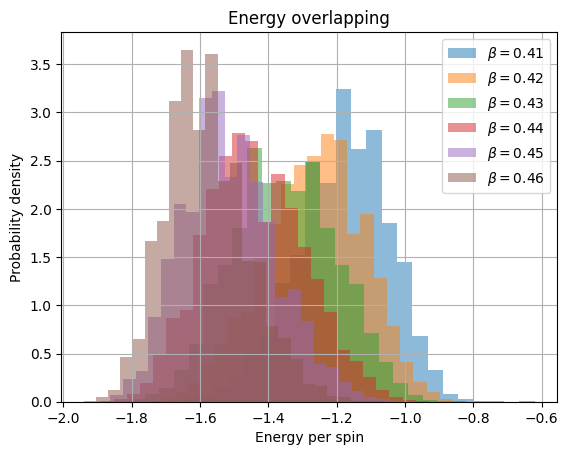

In [93]:
for i in i_list:
    plt.hist(data.iloc[t_eq:,i]/N, bins = 25, density = True, alpha=0.5, label = r'$\beta = {}$'.format(beta[i//2]))
plt.xlabel('Energy per spin')
plt.legend()
plt.ylabel('Probability density')
plt.title('Energy overlapping')
plt.grid()
plt.savefig('energy_overlapping_wolff')

### Magnetization autocorrelation

In [94]:
list_j = [2*j for j in range(1, len(beta)+1)]
t_eq=5000

In [95]:
list_j

[2, 4, 6, 8, 10, 12]

In [96]:
for b,j in enumerate(list_j):
    #computing averages and fluctuations of observables
    mag = np.array(np.abs(data.iloc[t_eq:,j]/N))
    av_mag = np.mean(mag)
    var_mag = np.mean((mag-av_mag)**2)
       
    #computing the correlation time of each observable
    C_mag = autocorrelation_function(mag)
    tau_mag = autocorrelation_time(C_mag)
    print('Autocorrelation time for beta=', beta[b], ':', tau_mag)

Autocorrelation time for beta= 0.41 : 3
Autocorrelation time for beta= 0.42 : 3
Autocorrelation time for beta= 0.43 : 3
Autocorrelation time for beta= 0.44 : 3
Autocorrelation time for beta= 0.45 : 2
Autocorrelation time for beta= 0.46 : 2


## Swap not alllowed

In [105]:
#choosing the file to analyze and loading the data
data = pd.read_csv(path+file_no_swap, sep="\t")

In [104]:
file_no_swap

'Ising_2D_MMC_wolff_NO_SWAP_N400_L20_Nchains6time30000.txt'

In [100]:
data

#time  en_beta=0.410000  mag_beta=0.410000  en_beta=0.420000  \
0          0              20.0                8.0             -20.0   
1          1              20.0                6.0             -24.0   
2          2              20.0                4.0             -24.0   
3          3              16.0                8.0             -24.0   
4          4               8.0               10.0             -36.0   
...      ...               ...                ...               ...   
29995  29995            -488.0             -258.0            -484.0   
29996  29996            -488.0             -260.0            -488.0   
29997  29997            -504.0             -268.0            -484.0   
29998  29998            -496.0              264.0            -520.0   
29999  29999            -452.0              152.0            -520.0   

       mag_beta=0.420000  en_beta=0.430000  mag_beta=0.430000  \
0                  -14.0              16.0               18.0   
1                    4.0              12.0               22.0   
2                    6.0              -8.0               42.0   
3                    8.0             -32.0               12.0   
4                   20.0             -40.0                6.0   
...                  ...               ...                ...   
29995             -222.0            -580.0             -302.0   
29996             -186.0            -576.0              228.0   
29997             -184.0            -584.0              226.0   
29998              262.0            -616.0             -310.0   
29999              258.0            -676.0              356.0   

       en_beta=0.440000  mag_beta=0.440000  en_beta=0.450000  \
0                  32.0                8.0               8.0   
1                  24.0               10.0               0.0   
2                  20.0               14.0              -8.0   
3                  12.0               12.0             -32.0   
4                  -4.0               18.0             -52.0   
...                 ...                ...               ...   
29995            -580.0              306.0            -596.0   
29996            -572.0              304.0            -600.0   
29997            -592.0             -306.0            -620.0   
29998            -600.0             -290.0            -632.0   
29999            -596.0              304.0            -544.0   

       mag_beta=0.450000  en_beta=0.460000  mag_beta=0.460000 swap  
0                  -20.0               0.0               -6.0   NO  
1                  -26.0             -24.0              -20.0   NO  
2                  -24.0             -32.0              -22.0   NO  
3                    4.0             -52.0              -12.0   NO  
4                   -8.0             -60.0              -16.0   NO  
...                  ...               ...                ...  ...  
29995             -262.0            -652.0              340.0   NO  
29996             -286.0            -620.0             -330.0   NO  
29997              334.0            -628.0             -340.0   NO  
29998             -336.0            -660.0              322.0   NO  
29999              278.0            -656.0             -350.0   NO  

[30000 rows x 14 columns]

In [101]:
list_j = [2*j for j in range(1, len(beta)+1)]
t_eq=5000

In [106]:
for b,j in enumerate(list_j):
    #computing averages and fluctuations of observables
    mag = np.array(np.abs(data.iloc[t_eq:,j]/N))
    av_mag = np.mean(mag)
    var_mag = np.mean((mag-av_mag)**2)
       
    #computing the correlation time of each observable
    C_mag = autocorrelation_function(mag)
    tau_mag = autocorrelation_time(C_mag)
    print('Autocorrelation time for beta=', beta[b], ':', tau_mag)

Autocorrelation time for beta= 0.41 : 3
Autocorrelation time for beta= 0.42 : 3
Autocorrelation time for beta= 0.43 : 3
Autocorrelation time for beta= 0.44 : 3
Autocorrelation time for beta= 0.45 : 2
Autocorrelation time for beta= 0.46 : 2
